================       Preference Setup        ================
Alpha: 0.01	 Lambda: 0.01	K: 10	Iteration number: 30
================ Start latent factor model fit ================
Iteration: 0 	Mean loss of train: 1.18 	Mean loss of validation: 1.44
Iteration: 10 	Mean loss of train: 0.76 	Mean loss of validation: 0.97

The latent factor model is convergent at iteration 19.

The predictive matrix is:
[[ 3.93173836  3.22561924  3.42439167 ...,  3.1380859   4.03990538
   2.94297367]
 [ 3.95499833  3.44098105  3.16246147 ...,  3.41703729  3.78826209
   2.57694278]
 [ 3.86283012  3.4064862   2.73642202 ...,  3.80139037  3.77179117
   2.61322559]
 ..., 
 [ 4.36812533  3.79732505  3.7120556  ...,  3.7242116   4.37990985
   3.06362244]
 [ 4.38949722  3.96223429  3.47577494 ...,  3.65695296  4.51383658
   3.67562676]
 [ 3.61599066  3.05257654  2.52483908 ...,  3.3152754   4.0107767
   2.65300225]]


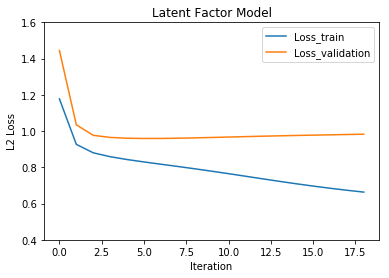

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

datasets_path = './ml-100k/' 
USER_NUM = 943          #用户数目
ITEM_NUM = 1682         #物品数目
ALPHA = 0.01            #学习率
LAMBDA = 0.01           #惩罚因子
K = 10                  #潜在特征数
ITER_NUM = 30           #最大迭代次数
CONVERGENT = 0.01       #判断收敛的阈值

#    draw the result
def draw_plot(Loss_train, Loss_validation):
    plt.plot(Loss_train, label="Loss_train")
    plt.plot(Loss_validation, label="Loss_validation")
    plt.legend()
    plt.ylim(0.4, 1.6)
    plt.xlabel("Iteration")
    plt.ylabel("L2 Loss")
    plt.title("Latent Factor Model")
    plt.show()

# 判断是否收敛
def is_convergent(loss_last, loss_cur):
    return math.fabs(loss_last - loss_cur) <= CONVERGENT

# 输出预测矩阵
def output_pred_mat(P, Q):
    R_pred = np.dot(P, Q.T)
    print("The predictive matrix is:")
    print(R_pred)

def lmf(R_trian, R_test):
    P = np.random.rand(USER_NUM, K)    #P[i][k]: 用户i和隐因子r的相关性
    Q = np.random.rand(ITEM_NUM, K)    #Q[j][k]: 商品j和隐因子r的相关性

    loss_his_train = []    #储存loss记录
    loss_his_test = []

    for iter in range(ITER_NUM):
        loss_train = []
        loss_test = []
        for i in range(USER_NUM):
            for j in range(ITEM_NUM):

                if math.fabs(R_trian[i][j]) > 1e-4:   #只训练非零元素
                    err_train_cur = R_trian[i][j] - np.dot(P[i], Q[j])   #当前误差
                    loss_train.append(err_train_cur ** 2)
                    # 梯度下降
                    for k in range(K):
                       # 计算梯度
                        gu = err_train_cur * Q[j][k] - LAMBDA * P[i][k]
                        gv = err_train_cur * P[i][k] - LAMBDA * Q[j][k]
                        P[i][k] += ALPHA * gu
                        Q[j][k] += ALPHA * gv

                if math.fabs(R_test[i][j]) > 1e-4:   #只验证非零元素
                    err_test_cur = R_test[i][j] - np.dot(P[i], Q[j])
                    loss_test.append(err_test_cur ** 2)

        loss_train = np.mean(loss_train)
        loss_test = np.mean(loss_test)
        # 判断是否已经收敛，收敛则不继续迭代
        if iter != 0 and is_convergent(loss_train, loss_his_train[-1]):
            print("\nThe latent factor model is convergent at iteration %d.\n" % iter)
            break
        else:
            loss_his_train.append(loss_train)
            loss_his_test.append(loss_test)

        if iter % 10 == 0:
            print("Iteration: %d \tMean loss of train: %.2f \tMean loss of validation: %.2f" %
                (iter, loss_train, loss_test))

    output_pred_mat(P, Q)
    return loss_his_train, loss_his_test

def load_ml_data(filename):
    #填充数据
    data = np.zeros((USER_NUM, ITEM_NUM))
    for line in open(datasets_path + filename, 'r'):
        (userid, movieid, rating, ts) = line.split('\t')
        (userid, movieid, rating) = map(int, (userid, movieid, rating))
        data[userid - 1, movieid - 1] = float(rating)
    return data           

if __name__=="__main__":
    train_data = load_ml_data('u1.base')
    test_data = load_ml_data('u1.test')
    print("================       Preference Setup        ================")
    print("Alpha: %.2f\t Lambda: %.2f\tK: %d\tIteration number: %d" % (ALPHA, LAMBDA, K, ITER_NUM))
    print("================ Start latent factor model fit ================")
    loss_his_train, loss_his_test = lmf(train_data, test_data)
    draw_plot(loss_his_train, loss_his_test)

    